This example uses the data provided in https://www.nature.com/articles/s41586-021-03569-1

In [1]:
import scanpy as sc

there's 26 different samples. I'm just going to start with the first
control sample. Scanpy requires the columns to be genes in the rows to be cells so we
just have to pass the transpose.

#cells
#adata.obs
#genes
#adata.var
#counts
#adata.X.shape # it gives cells by numer of genes

In [3]:
adata = sc.read_csv("GSE171524_RAW/GSM5226574_C51ctr_raw_counts.csv.gz").T
#cells x genes
adata

AnnData object with n_obs × n_vars = 6099 × 34546

# Doublet removal 

For the pre-processing, we're going to start with doublet removal. This is applied to single sample.

In [4]:
import scvi
sc.pp.filter_genes(adata,min_cells=10) #keep genes that are found in at least 10 of the cells

Global seed set to 0


we're going to go ahead and only keep the 2000 top variable genes. 2000 genes that more or less describe the data the best

In [5]:
sc.pp.highly_variable_genes(adata,n_top_genes=2000,subset=True,flavor='seurat_v3') 

Now we set up an scvi model so that we can then predict the doublets. We use a very simple model setup using only default parameters and then we're training this vae model. This will take a few minutes especially if you don't have an nvidia gpu.

In [6]:
scvi.model.SCVI.setup_anndata(adata)
vae=scvi.model.SCVI(adata)
vae.train()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|███████| 400/400 [07:01<00:00,  1.03it/s, loss=320, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████| 400/400 [07:01<00:00,  1.05s/it, loss=320, v_num=1]


Train the solo model which predicts doublets and we just passed the vae model we just trained so once that's done we can get the predictions for whether a cell is a doublet or not

In [7]:
solo =scvi.external.SOLO.from_scvi_model(vae)
solo.train()

INFO     Creating doublets, preparing SOLO model.                                                                  


/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 237/400:  59%|██▉  | 237/400 [01:24<00:57,  2.82it/s, loss=0.288, v_num=1]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.307. Signaling Trainer to stop.


We can get the predictions for whether a cell is a doublet or not so you see we can return a data frame. We have the cell barcode and the score for doublet and seamlet the higher of the scores is going to be the prediction. I'm also going to pass soft equals true to make a new column that is the predicted label so now we have the values and the prediction there's one final thing i want to do which is to remove all these dash zeros that scbi adds on to the barcodes.

In [8]:
df=solo.predict()
df['prediction'] = solo.predict(soft=False)
df.index=df.index.map(lambda x: x[:-2])

In [9]:
df.groupby('prediction').count() #count how many doublets and singlets we have

,doublet,singlet
prediction,,
doublet,1146,1146
singlet,4953,4953


Add a new column in this data frame which is the difference between doublet and singlet

In [10]:
df['dif']=df.doublet-df.singlet
df

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1_1,0.977241,-2.309904,doublet,3.287146
ATTCACTGTAACAGGC-1_1,0.965597,-2.311976,doublet,3.277574
TAACTTCCAACCACGC-1_1,-0.326662,-0.127030,singlet,-0.199633
TTGGGTACACGACAAG-1_1,0.484909,-1.355743,doublet,1.840652
AGGCCACAGAGTCACG-1_1,0.288798,-1.861817,doublet,2.150615
...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,-2.586984,1.799036,singlet,-4.386020
CACTGGGGTCTACGTA-1_1,-3.608599,3.138040,singlet,-6.746639
CATACTTGTAGAGGAA-1_1,-2.999091,2.722837,singlet,-5.721928
TTTGGTTTCCACGGAC-1_1,-2.534811,3.048507,singlet,-5.583319


Plot the distribution of the dif column in the dataframe using only the cells that were predicted doublet

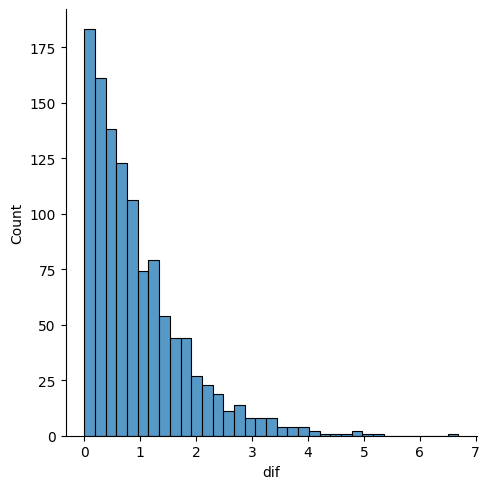

In [11]:
import seaborn as sns
sns.displot(df[df.prediction=='doublet'],x='dif')

You see we have a lot of cells predicted doublet that were only marginally higher than the prediction for singlet. I'm going to filter out the ones below one (one is kind of an arbitrary selection) to make a new data frame called doublets which is only the cell's predicted doublet and with the difference above one, i.e. everything to the right of the one here on this distribution.

In [12]:
doublets=df[(df.prediction=='doublet')&(df.dif>1)]
doublets

,doublet,singlet,prediction,dif
TAGGTACCATGGCCAC-1_1,0.977241,-2.309904,doublet,3.287146
ATTCACTGTAACAGGC-1_1,0.965597,-2.311976,doublet,3.277574
TTGGGTACACGACAAG-1_1,0.484909,-1.355743,doublet,1.840652
AGGCCACAGAGTCACG-1_1,0.288798,-1.861817,doublet,2.150615
CACTGAAGTCGAAGCA-1_1,0.316726,-1.860881,doublet,2.177607
...,...,...,...,...
TTGCTGCAGTGCGACA-1_1,0.575707,-0.893823,doublet,1.469530
ATCAGGTGTCGTCTCT-1_1,0.804171,-0.484398,doublet,1.288568
CAACAACAGGTGCTTT-1_1,0.821832,-1.188426,doublet,2.010259
CATCCCAAGACGCCAA-1_1,0.479079,-0.779022,doublet,1.258101


Load again raw data

In [13]:
adata = sc.read_csv("GSE171524_RAW/GSM5226574_C51ctr_raw_counts.csv.gz").transpose()

Filter out all the cells that were labeled true and keep all the cells that were labeled false as doublets to obtain our fresh raw as a data object with the doublets removed

In [14]:
adata.obs['doublet']=adata.obs.index.isin(doublets.index)
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,True
ATTCACTGTAACAGGC-1_1,True
TAACTTCCAACCACGC-1_1,False
TTGGGTACACGACAAG-1_1,True
AGGCCACAGAGTCACG-1_1,True
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [15]:
adata=adata[~adata.obs.doublet]

In [16]:
adata

View of AnnData object with n_obs × n_vars = 5681 × 34546
    obs: 'doublet'

# Preprocessing

Label the genes that are mitochondrial genes

In [17]:
adata.var[adata.var.index.str.startswith('MT-')]

""
MT-ND1
MT-ND2
MT-CO1
MT-CO2
MT-ATP8
MT-ATP6
MT-CO3
MT-ND3
MT-ND4L
MT-ND4


In [18]:
adata.var['mt']=adata.var.index.str.startswith('MT-')

/tmp/ipykernel_46033/1380960737.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['mt']=adata.var.index.str.startswith('MT-')


In [19]:
adata.var

,mt
AL627309.1,False
AL627309.5,False
AL627309.4,False
AL669831.2,False
LINC01409,False
...,...
VN1R2,False
AL031676.1,False
SMIM34A,False
AL050402.1,False


Let's do the same thing for ribosomal genes. I'm going to use a list of known ribosomal genes from the broad institute

In [20]:
import pandas as pd
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [21]:
ribo_genes=pd.read_table(ribo_url,skiprows=2,header=None) #read the URL
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [22]:
adata.var['ribo']=adata.var_names.isin(ribo_genes[0].values) #like annotating mitochondrial genes we're going to do the same thing here
adata.var

,mt,ribo
AL627309.1,False,False
AL627309.5,False,False
AL627309.4,False,False
AL669831.2,False,False
LINC01409,False,False
...,...,...
VN1R2,False,False
AL031676.1,False,False
SMIM34A,False,False
AL050402.1,False,False


Compute Quality Control (QC) metrics.
Here QC vars correspond to those columns that we made with the true or false labels.

In [23]:
sc.pp.calculate_qc_metrics(adata,qc_vars=['mt','ribo'],percent_top=None,log1p=False,inplace=True)

In [24]:
# we now have these statistics for each of the genes. See that the percent
# dropout "pct_dropout_by_counts" is very high for a majority of the genes
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,False,False,6,0.001056,99.894385,6.0
AL627309.5,False,False,26,0.004577,99.542334,26.0
AL627309.4,False,False,3,0.000528,99.947192,3.0
AL669831.2,False,False,1,0.000176,99.982397,1.0
LINC01409,False,False,236,0.045062,95.845802,256.0
...,...,...,...,...,...,...
VN1R2,False,False,0,0.000000,100.000000,0.0
AL031676.1,False,False,0,0.000000,100.000000,0.0
SMIM34A,False,False,0,0.000000,100.000000,0.0
AL050402.1,False,False,0,0.000000,100.000000,0.0


In [25]:
# we now have these stats which includes mitochondrial counts "total_counts_mt" and "pct_counts_mt" for the
# percent of the mitochondrial reads and the percent of the ribosomal reads "pct_counts_ribo" for that given
# cell along with the number of genes "n_genes_by_counts" that were positive in that cell where the
# number of genes that had any counts and then the total number of umis
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAACTTCCAACCACGC-1_1,False,5158,15645.0,221.0,1.412592,211.0,1.348674
TTACCGCCACTCAGAT-1_1,False,4144,11369.0,39.0,0.343038,5.0,0.043979
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319
CGCATAACATGCCGGT-1_1,False,3745,8617.0,119.0,1.380991,25.0,0.290124
TCTATCACAAGGCTTT-1_1,False,3582,8276.0,183.0,2.211213,5.0,0.060416
...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827


In [26]:
adata.var.sort_values('n_cells_by_counts')#  sort it by the number of cells that a gene was found in

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL445072.1,False,False,0,0.000000,100.000000,0.0
AC113615.1,False,False,0,0.000000,100.000000,0.0
AC097381.2,False,False,0,0.000000,100.000000,0.0
AC084048.1,False,False,0,0.000000,100.000000,0.0
AC006445.3,False,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...
AKAP13,False,False,4080,2.844746,28.181658,16161.0
MBNL1,False,False,4166,2.673121,26.667840,15186.0
NEAT1,False,False,4172,5.018835,26.562225,28512.0
ZBTB20,False,False,4309,2.408731,24.150678,13684.0


In [27]:
sc.pp.filter_genes(adata,min_cells=3) # filter out the genes that weren't in at least three cells

In [29]:
adata.var.sort_values('n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
AC010230.1,False,False,3,0.000528,99.947192,3.0,3
AL121820.2,False,False,3,0.000528,99.947192,3.0,3
AL157996.2,False,False,3,0.000528,99.947192,3.0,3
AC011351.1,False,False,3,0.000528,99.947192,3.0,3
AL160191.1,False,False,3,0.000704,99.947192,4.0,3
...,...,...,...,...,...,...,...
AKAP13,False,False,4080,2.844746,28.181658,16161.0,4080
MBNL1,False,False,4166,2.673121,26.667840,15186.0,4166
NEAT1,False,False,4172,5.018835,26.562225,28512.0,4172
ZBTB20,False,False,4309,2.408731,24.150678,13684.0,4309


we would run something like this so we'd filter the cells. For instance,
in this case with the minimum genes 200

In [28]:
adata.obs.sort_values('total_counts')

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CGAGAAGGTGAACTAA-1_1,False,308,401.0,0.0,0.000000,0.0,0.000000
CAGGGCTTCATGCGGC-1_1,False,330,401.0,7.0,1.745636,1.0,0.249377
CTCAACCGTTTGGGAG-1_1,False,325,401.0,0.0,0.000000,0.0,0.000000
GTCGTTCTCCAAGGGA-1_1,False,300,401.0,0.0,0.000000,0.0,0.000000
TGGTACAGTTGGTGTT-1_1,False,323,401.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...
TCTATCACAAGGCTTT-1_1,False,3582,8276.0,183.0,2.211213,5.0,0.060416
CGCATAACATGCCGGT-1_1,False,3745,8617.0,119.0,1.380991,25.0,0.290124
TTACCGCCACTCAGAT-1_1,False,4144,11369.0,39.0,0.343038,5.0,0.043979
TTGGTTTTCCTAGCTC-1_1,False,3902,11472.0,463.0,4.035913,13.0,0.113319


In [29]:
sc.pp.filter_cells(adata,min_genes=200)

Plot some of these QC metrics.
Use these qc metrics to get rid of outliers. For example, if a cell has significantly higher
genes than the average, there's a chance that it's some artifact. Likewise with
counts but these are very highly correlated so we can filter on one and then if there's a high mitochondrial percentage then it could be a sequencing artifact.
Usually people set a mitochondrial filter anywhere from 5 to 20 percent

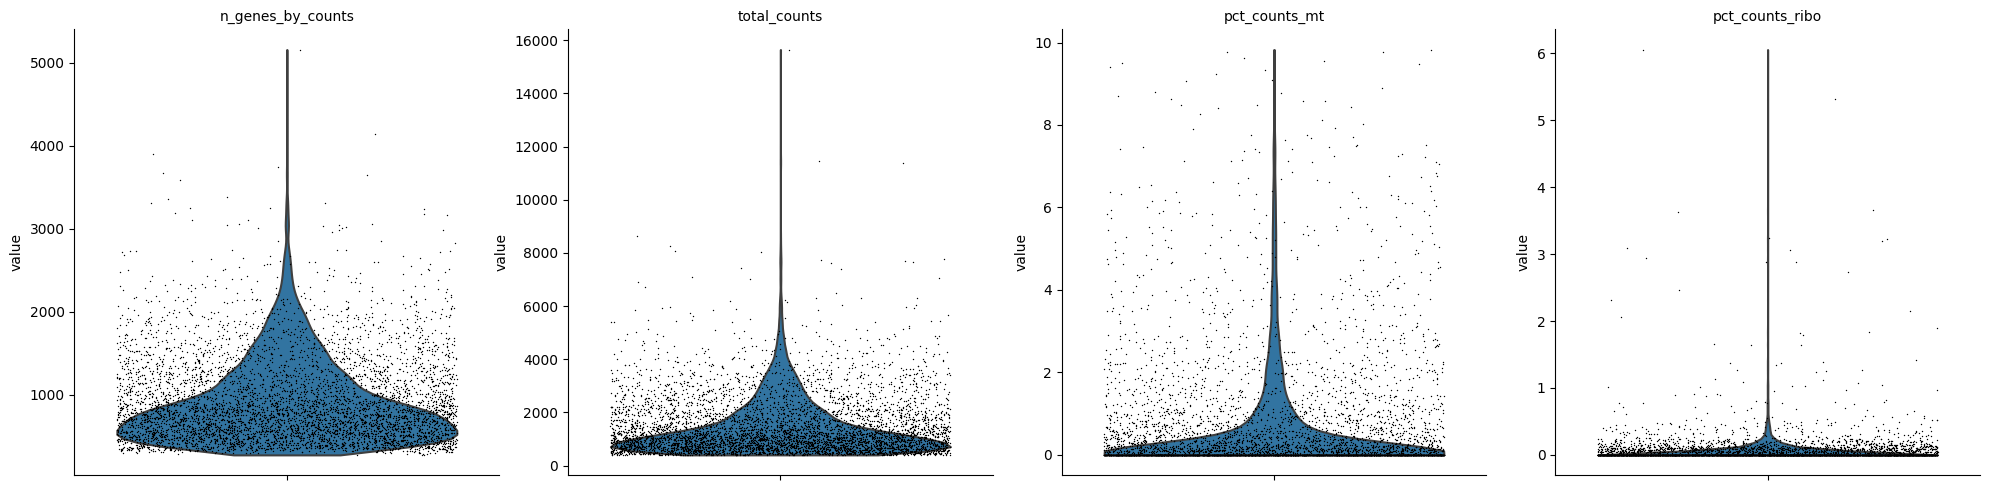

In [30]:
sc.pl.violin(adata,['n_genes_by_counts','total_counts','pct_counts_mt','pct_counts_ribo'],jitter=0.4,multi_panel=True)

In [31]:
import numpy as np
#get the 98 percentile value and then filter the genes
upper_lim=np.quantile(adata.obs.n_genes_by_counts.values,0.98)
#you can pick an specific value by
#upper_lim=3000

In [32]:
upper_lim

2267.399999999996

In [33]:
adata=adata[adata.obs.n_genes_by_counts<upper_lim]
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2120
GATGATCCACAACCGC-1_1,False,2263,4938.0,2.0,0.040502,2.0,0.040502,2261
TCATGCCGTCTTTCAT-1_1,False,2234,4993.0,0.0,0.000000,3.0,0.060084,2229
GATAGCTCAGGCTTGC-1_1,False,2167,4879.0,0.0,0.000000,0.0,0.000000,2165
TACATTCGTACGTACT-1_1,False,2253,4776.0,13.0,0.272194,1.0,0.020938,2250
...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,355
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,346
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,360
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,299


In [34]:
#similarly we can filter outliers of pct_counts_mt and pct_counts_ribo
adata=adata[adata.obs.pct_counts_mt<20]
adata=adata[adata.obs.pct_counts_ribo<2]

In [35]:
adata

View of AnnData object with n_obs × n_vars = 5550 × 24171
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

# Normalization

Normalization is an important step because in single cell sequencing there's a lot of variation between cells even between the same cell type just because of sequencing biases etc Hence, we need to do normalization to compare cells and compare genes if we look at the a data

In [40]:
adata.X.sum(axis=1)#  just to show you let's just take the sum of each cell

ArrayView([5250., 4936., 4988., ...,  410.,  405.,  410.], dtype=float32)

In [36]:
sc.pp.normalize_total(adata,target_sum=1e4) #normalize the counts in each cell so that 
#their total counts adds up to the same value

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [42]:
adata.X.sum(axis=1)# Now they sum up to 1e4 each

array([10000.001, 10000.   ,  9999.999, ..., 10000.   , 10000.   ,
       10000.   ], dtype=float32)

Computes $X=\log(X+1)$, where $\log$ denotes the natural logarithm unless a different base is given.

In [37]:
sc.pp.log1p(adata)#change to log counts 
adata.X.sum(axis=1) # now they're not going to be all the same because
#it's not a linear transformation but they're still all comparable or at least more comparable than before

array([2858.1604, 3252.1775, 3191.3235, ..., 1191.2706, 1022.7511,
       1162.8785], dtype=float32)

In [38]:
adata.raw=adata # freeze the data as it is now

# Clustering

In [39]:
sc.pp.highly_variable_genes(adata,n_top_genes=2000) # find the 2000 most variable genes 

In [40]:
adata.var

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AL627309.1,False,False,6,0.001056,99.894385,6.0,6,True,0.011018,2.764073,1.264226
AL627309.5,False,False,26,0.004577,99.542334,26.0,26,False,0.028334,2.316767,-0.098105
AL627309.4,False,False,3,0.000528,99.947192,3.0,3,False,0.002503,1.702828,-1.967941
LINC01409,False,False,236,0.045062,95.845802,256.0,236,False,0.267393,2.328450,-0.062525
FAM87B,False,False,6,0.001056,99.894385,6.0,6,False,0.007175,1.947629,-1.222366
...,...,...,...,...,...,...,...,...,...,...,...
AL354822.1,False,False,119,0.021651,97.905298,123.0,119,False,0.155097,2.416304,0.205047
AL592183.1,False,False,864,0.179370,84.791410,1019.0,864,False,0.870335,2.511893,-0.383148
AC240274.1,False,False,146,0.026580,97.430030,151.0,146,False,0.152593,2.298022,-0.155196
AC007325.4,False,False,4,0.000704,99.929590,4.0,4,False,0.003007,1.579803,-2.342630


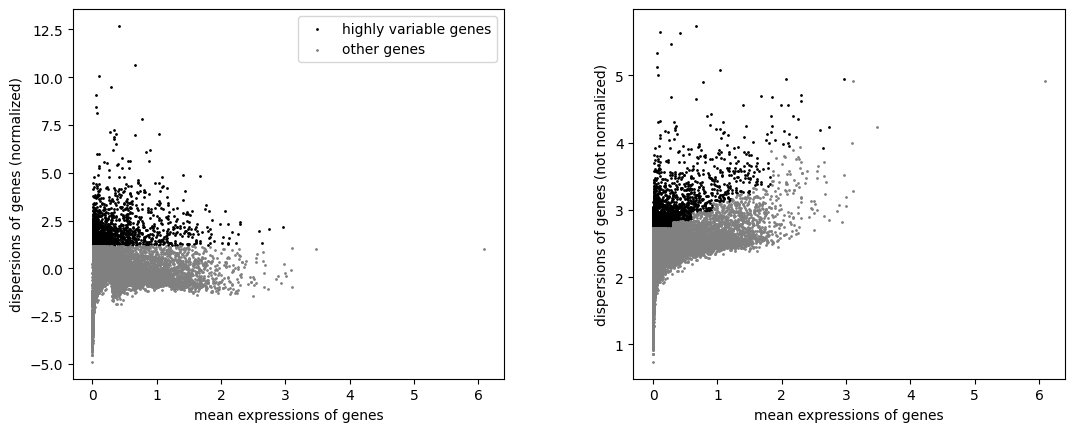

In [41]:
sc.pl.highly_variable_genes(adata) #genes with higher dispersion were marked as variable genes

In [42]:
adata=adata[:,adata.var.highly_variable] # filter out the not highly variable genes 

In [43]:
adata

View of AnnData object with n_obs × n_vars = 5550 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

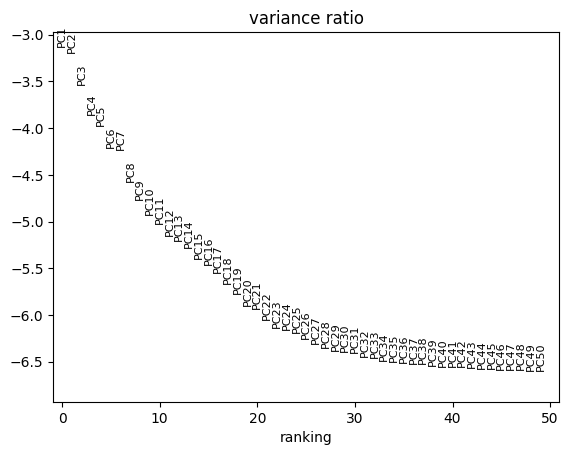

In [44]:
#now we're going to regress out the differences
#that arise due to the total number of counts mitochondrial counts and the ribosomal counts 
#this will get rid of some of the variations in the data that are due to processing and 
#just sample quality sequencing artifact etc
sc.pp.regress_out(adata,['total_counts','pct_counts_mt','pct_counts_ribo'])

#normalize each
#gene to the unit variance of that gene
sc.pp.scale(adata, max_value=10)

# run principal component analysis to further reduce the
#dimensions of the data by default this calculates 50 pcs
sc.tl.pca(adata, svd_solver='arpack')

#plot how much these pcs actually
#contribute to the data
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

We want to find the elbow at the previous plot, i.e., where you don't really see a big difference as you increase the pc number. Here around 30 you see that it really starts to flatten out, so 30 is probably a good number to pick.

In [45]:
sc.pp.neighbors(adata,n_pcs=30)

In [46]:
adata

AnnData object with n_obs × n_vars = 5550 × 2000
    obs: 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [47]:
# neighborhood matrices that are what's going to be used to do the clustering
adata.obsp['connectivities'].toarray()
adata.obsp['distances'].toarray()

array([[0.        , 5.20606518, 4.14763546, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.72114921, ..., 0.        , 0.        ,
        0.        ],
       [4.14763546, 3.72114921, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Use umap to project the data from the 30 dimensions into two dimensions. In the umap plot, one point is a single cell but they haven't been assigned to clusters yet so it's just all one color

In [48]:
sc.tl.umap(adata)

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


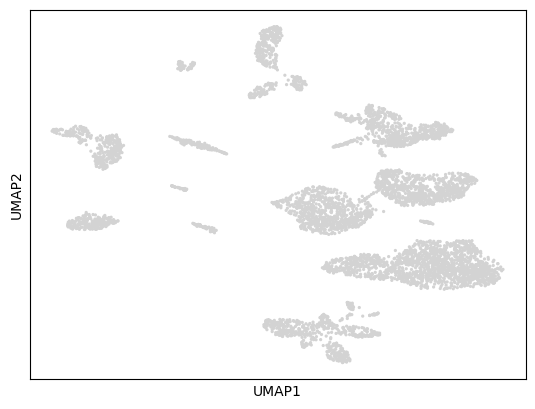

In [49]:
sc.pl.umap(adata)

In [50]:
#assign clustering we need to run the
#latent algorithm 
sc.tl.leiden(adata,resolution=0.5) #resolution closer to 1 = more clusters

In [51]:
adata.obs

,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden
ATACTTCCAAGGTCTT-1_1,False,2122,5252.0,1.0,0.019040,4.0,0.076161,2120,2
GATGATCCACAACCGC-1_1,False,2263,4938.0,2.0,0.040502,2.0,0.040502,2261,2
TCATGCCGTCTTTCAT-1_1,False,2234,4993.0,0.0,0.000000,3.0,0.060084,2229,2
GATAGCTCAGGCTTGC-1_1,False,2167,4879.0,0.0,0.000000,0.0,0.000000,2165,2
TACATTCGTACGTACT-1_1,False,2253,4776.0,13.0,0.272194,1.0,0.020938,2250,7
...,...,...,...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,False,355,410.0,3.0,0.731707,0.0,0.000000,355,7
CACTGGGGTCTACGTA-1_1,False,346,403.0,0.0,0.000000,0.0,0.000000,346,1
CATACTTGTAGAGGAA-1_1,False,360,410.0,2.0,0.487805,0.0,0.000000,360,0
TTTGGTTTCCACGGAC-1_1,False,299,405.0,0.0,0.000000,2.0,0.493827,299,5


/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


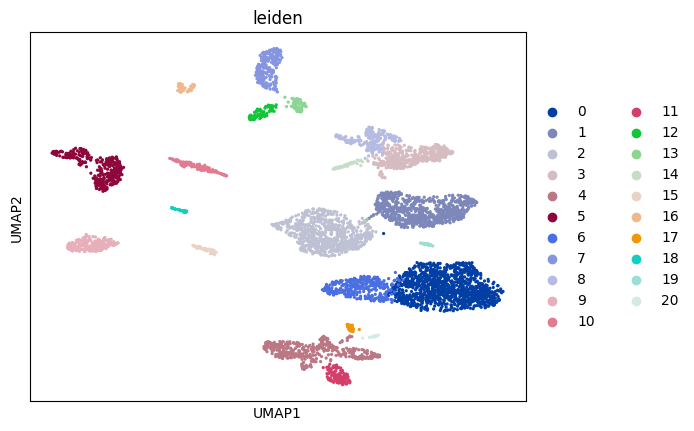

In [52]:
#re-plot that umap and color the cells based on leiden label
sc.pl.umap(adata,color=['leiden'])

# Integration
Integration of multiple samples
We have 26 samples. 
Integrate them all into one a data object and adjust for differences based on batch 

The following function:
* Predicts the doublets
* adding a new column in the observation data frame called sample which i'm just taking         the csv path splitting it on the underscore and then returning the second
* including a minimum genes threshold just in case some samples had fewer and the difference   here is that i got rid of the gene filtering i'm not filtering any genes out of any of the   samples for now
* calculating the mitochondrial statistics the ribosomalstatistics and then filtering out the   outliers
* 

In [62]:
def pp(csv_path):
    adata = sc.read_csv(csv_path).T
    sc.pp.filter_genes(adata, min_cells = 10)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, flavor = 'seurat_v3')
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    df['prediction'] = solo.predict(soft = False)
    df.index = df.index.map(lambda x: x[:-2])
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
    
    adata = sc.read_csv(csv_path).T
    adata.obs['Sample'] = csv_path.split('_')[2] #'raw_counts/GSM5226574_C51ctr_raw_counts.csv'
    
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    
    sc.pp.filter_cells(adata, min_genes=200) #get rid of cells with fewer than 200 genes
    #sc.pp.filter_genes(adata, min_cells=3) #get rid of genes that are found in fewer than 3 cells
    adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 20]
    adata = adata[adata.obs.pct_counts_ribo < 2]

    return adata

In [ ]:
#get all raw counts into one list, WARNING: it takes a lot of time
import os
out =[]
for file in os.listdir("GSE171524_RAW/"):
    out.append(pp("GSE171524_RAW/"+file))

In [ ]:
# let's combine all of the
# objects within the outlist into one a data object
adata= sc.concat(out)
adata

In [ ]:
adata.obs

In [ ]:
#  get rid of the genes that aren't in any of the cells or 
# in a few number of the cells. I'm just going to pick the genes 
# that are in at least 10 cells
sc.pp.filter_genes(adata, min_cells =10 )

In [ ]:
# convert x to a sparse matrix to reduce the size of the
# file and the amount of memory it takes to use i theoretically could have done it on each individual sample before i
# concatenated them inside the function but i have enough memory to do it this way so this step isn't necessary if you
# only have a few samples
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)

In [ ]:
adata.X

In [ ]:
#save it as an h5ad
adata.write_h5ad("combined.h5ad")

In [ ]:
#re-read it
adata= sc.read_h5ad("combined.h5ad")
adata

In [ ]:
#look at how many cells we have for each sample we can do a group by count
adata.obs.groupby('Sample').count()

In [ ]:
# get rid of the genes that aren't in at least 100 cells
sc.pp.filter_genes(adata,min_cells = 100)

Now, do the actual integration so the data is combined but we need to correct for batch effect and other things like mitochondrial counts and ribosomal counts 

In [ ]:
#save raw data
#this data hasn't been normalized it hasn't been converted to log or anything
adata.layers['counts']=adata.X.copy() 

In [ ]:
#normalize
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw=adata

In [ ]:
#just to remind everybody what we have
adata.obs.head()

In [ ]:
#find the highly variable genes only the top 3 000 you can pick more if you
# had more cells but if you had 10 000 cells 3 000 would be good make sure 
#to point at that counts layer
sc.pp.highly_variable_genes(adata, n_top_genes=3000,subset=True,layer='counts',
                           flavor='seurat_v3',batch_key='Sample') #no batch_key if one sample

In [ ]:
#do an actual model for this combined sample 
scvi.model.SCVI.setup_anndata(adata,layer='counts',
                             categorical_covariate_keys=['Sample'],
                             continouos_covariate_keys=['ptc_counts_mt','total_counts','pct_counts_ribo'])

In [ ]:
#train the model
model=scvi.model.SCVI(adata)
model.train() #takes a while

In [ ]:
#we can use get latent representation. 
#If we look at it it's just a numpy array where it's the number of cells is equal
#to the number of rows 
# we're going to be using this for clustering and umap
model.get_latent_representation().shape
#save it
adata.obs['X_scVI']=model.get_latent_representation()

In [ ]:
#get the scvi normalized expression which is a cell by
#gene data frame. We're going to save this as a layer 
#instead of overriding the default raw values.
#we're going to save this to scvi normalized as another layer
#in the a data object 
adata.layers['scvi_normalized']=model.get_normalized_expression(library_size=1e4)


In [ ]:
# do the clustering
# we're using the latent
#representation from scvi to calculate the neighbors
sc.pp.neighbors(adata,use_rep='X_scVI')

In [ ]:
#once we calculate the neighbors we're just going to run umap and since the neighbors were calculated using xsevi we
# don't have to specify anything here and then again likewise with laden we're
#just doing default settings except with a resolution of 0.5 which we might change later and since we have 90 000
#cells this might take a minute or two
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)

In [ ]:
#we're going to plot two u-maps one with the clusters labeled and
#then also one with the samples labeled so we can see how the integration went
sc.pl.umap(adata, color=['leiden','Sample'],frameon=False)

In [ ]:
adata.write_h5ad('integrated.h5ad')

# Find markers/label cell types

In [53]:
# we're going to get the marker genes just based
#on the laiden
sc.tl.rank_genes_groups(adata,'leiden')

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: Da

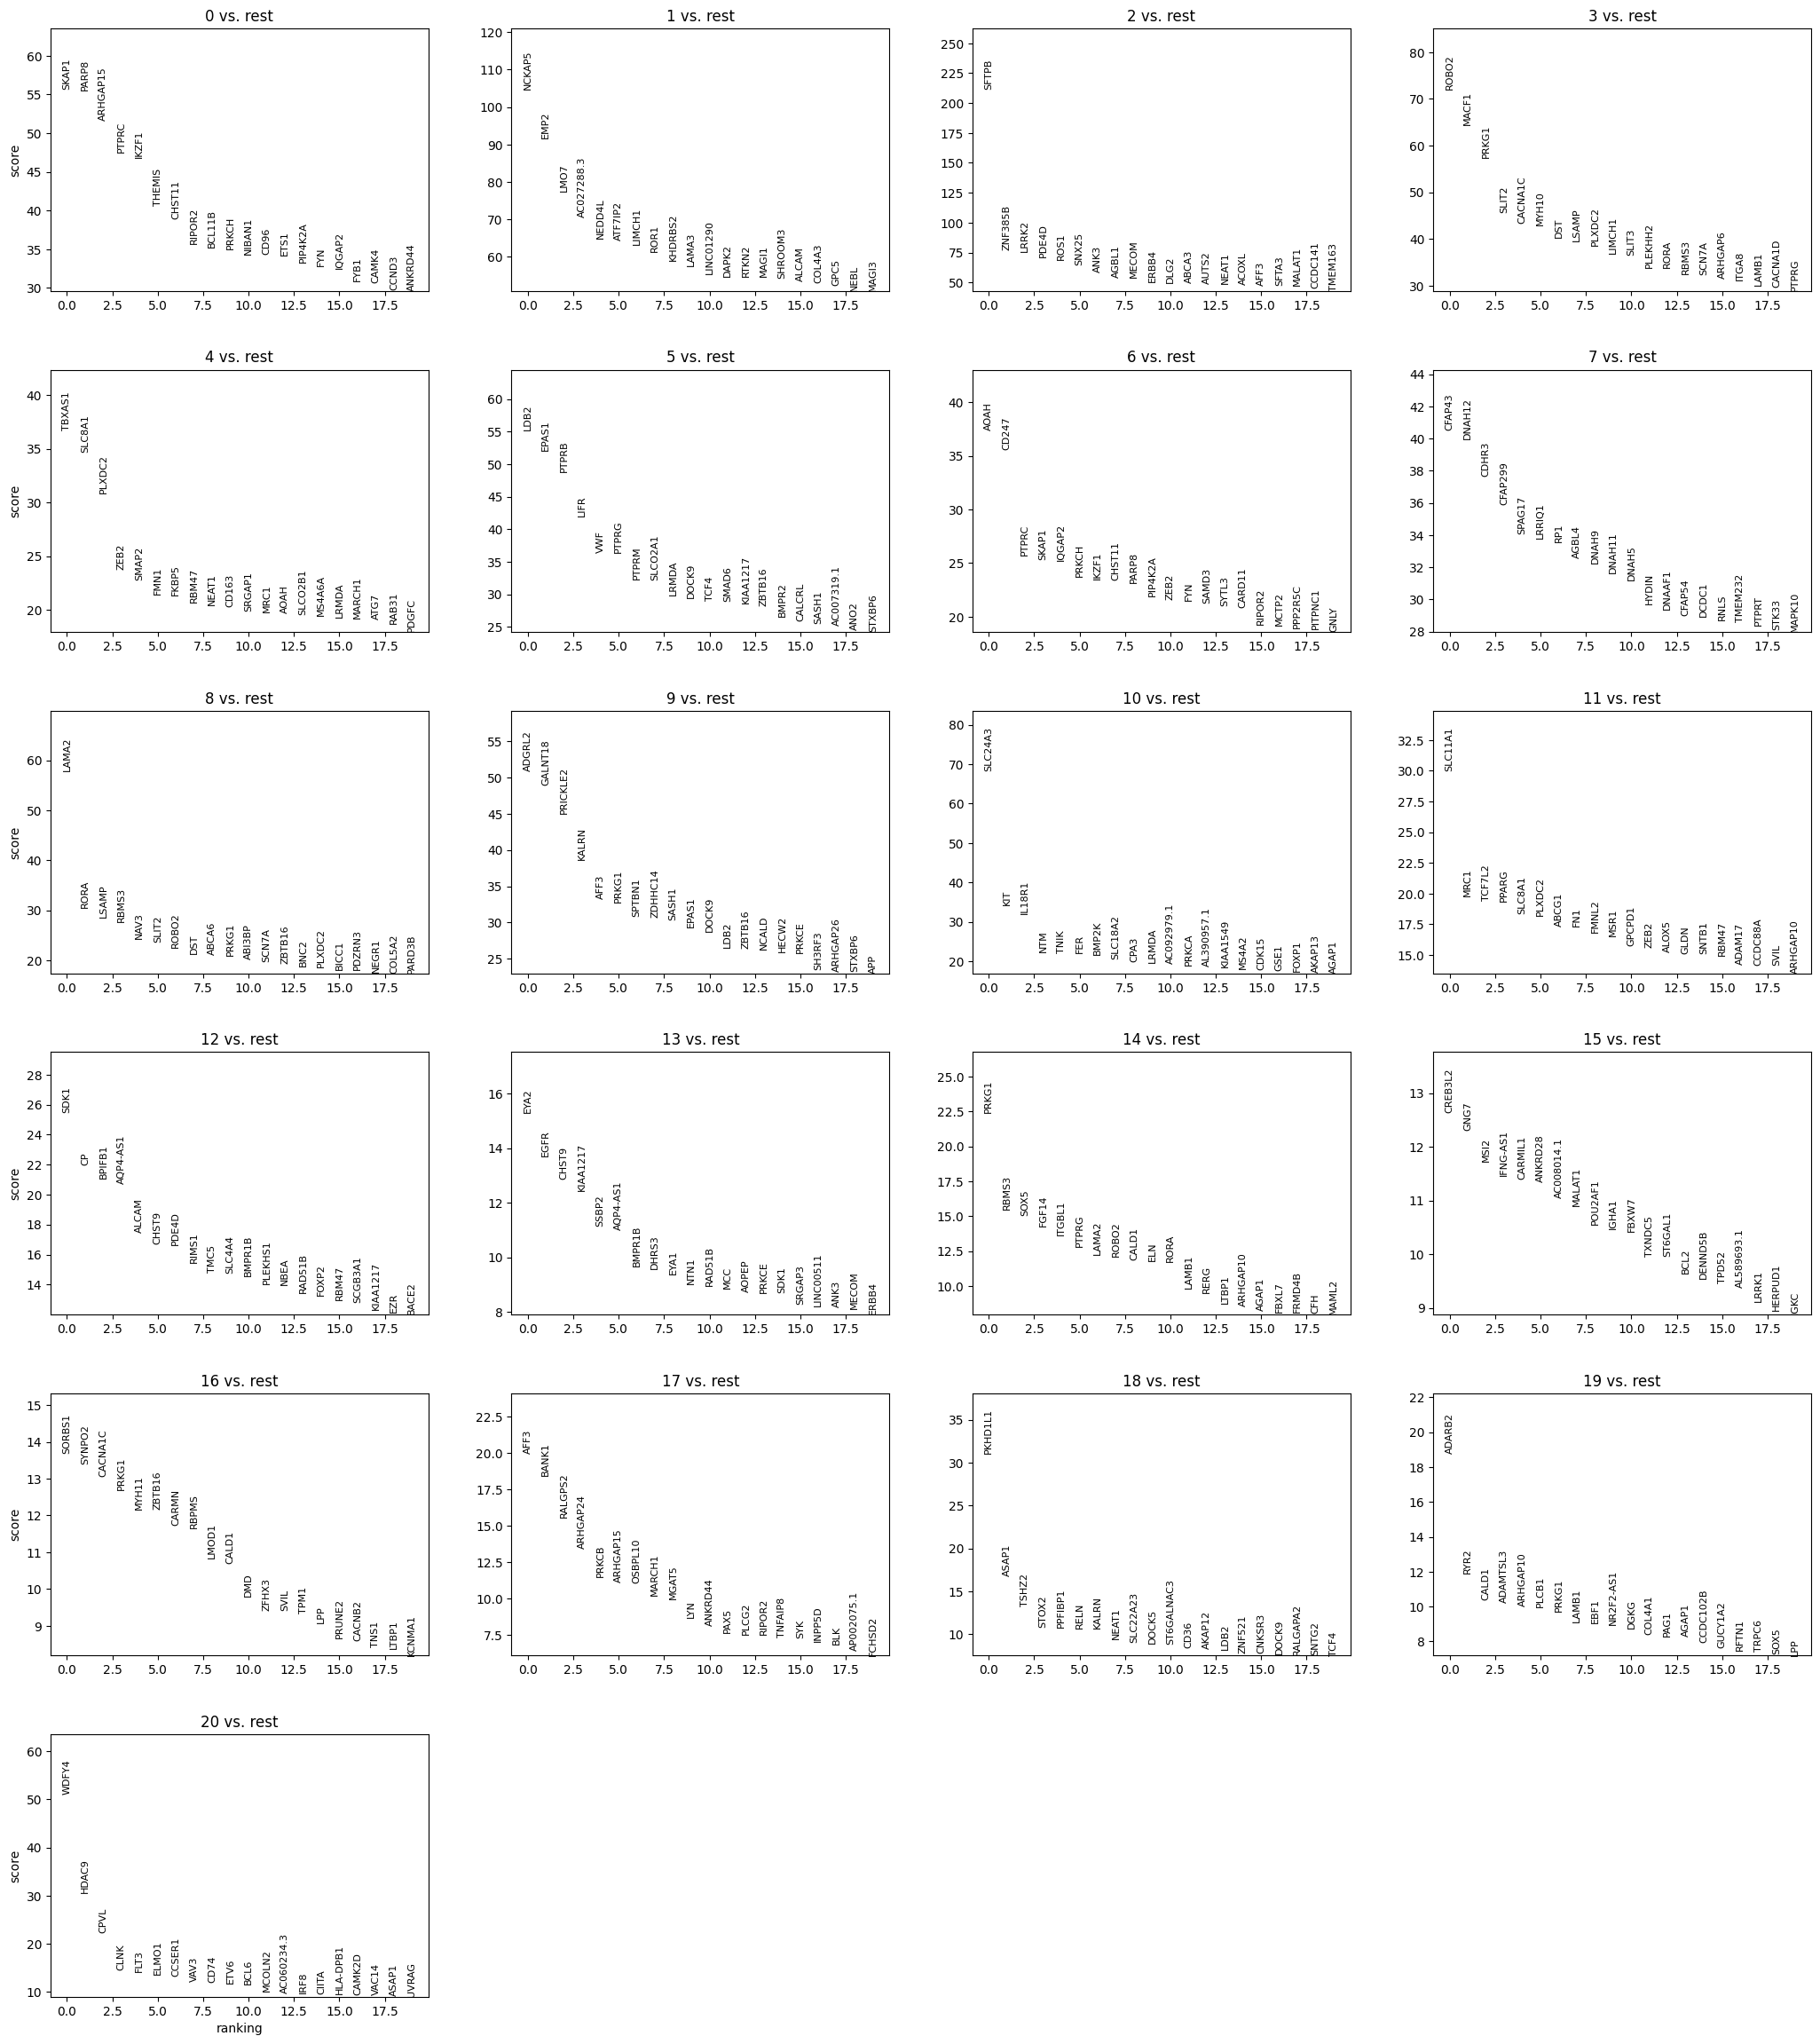

In [54]:
#this updates a new layer in the a data object which we can plot with this function here so
#i'm going to plot a marker genes or the rank genes group and just show the top 20 for each cluster
#each of these is just a different gene symbol, on the left we have the most significant 
sc.pl.rank_genes_groups(adata,n_genes=20,sharey=False)

In [56]:
# save this as markers and then i'm also going to filter everything with a p value adjusted of less than .05
# and keep only the ones with the log full change of at least 0.5
markers=sc.get.rank_genes_groups_df(adata,None)
markers=markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges> 0.5)]

In [ ]:
# we can use our svi model we're calling the differential expression function from our model and again
#grouping by laiden
markers_scvi=vae.differential_expression(groupby = 'leiden')
markers_scvi

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


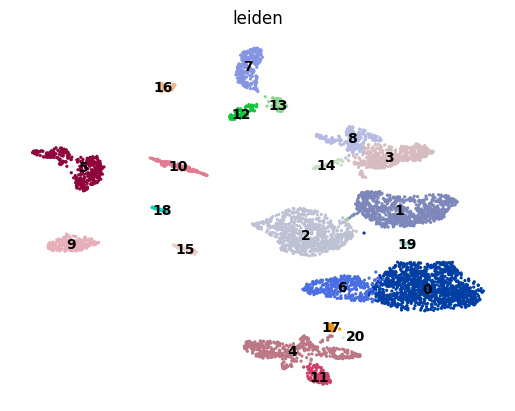

In [59]:
sc.pl.umap(adata,color=['leiden'],frameon =False, legend_loc="on data")

In [60]:
#i'm going to make a dictionary that goes
#from 0 to 20 and then just manually fill 
#it out when i've decided what a cluster is
for x in range(0,20):
    print(f'"{x}":"",')

"0":"",
"1":"",
"2":"",
"3":"",
"4":"",
"5":"",
"6":"",
"7":"",
"8":"",
"9":"",
"10":"",
"11":"",
"12":"",
"13":"",
"14":"",
"15":"",
"16":"",
"17":"",
"18":"",
"19":"",


In [64]:
#This is going to be our dictionary and when we've decided what
#cluster 0 is for example you can put the cell name here and then 
#we'll use this to map the cell labels

cell_type = {"0":"Macrophage",
"1":"Fibroblast",
"2":"CD4+ T-cell",
"3":"AT2",
"4":"AT1",
"5":"CD8+ T-cell",
"6":"Endothelial cell",
"7":"Plasma cell",
"8":"Macrophage",
"9":"AT2",
"10":"Fibroblast",
"11":"Fibroblast",
"12":"Macrophage",
"13":"Macrophage",
"14":"Airway epithelial",
"15":"Airway epithelial",
"16":"Monocyte",
"17":"Airway epithelial",
"18":"B-cell",
"19":"Aerocyte",
"20":"Airway epithelial",
"21":"Smooth muscle cell",
"22":"Cycling T/NK",
"23":"Neuronal cell",
"24":"Denditic cell",
"25":"Pericyte",
"26":"Fibroblast",
"27":"Erythroid-like",
"28":"Macrophage"
}

In [65]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

/home/ag1028/demo/notebookenv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


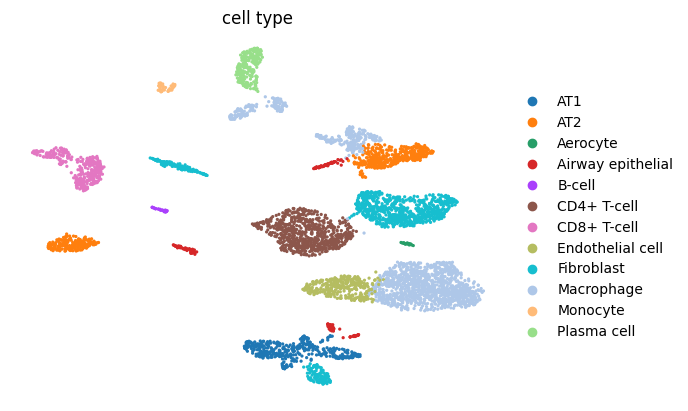

In [66]:
sc.pl.umap(adata, color = ['cell type'], frameon = False)

In [ ]:
#save integration
adata.uns['scvi_markers'] = markers_scvi
adata.uns['markers'] = markers
adata.write_h5ad('integrated.h5ad')
model.save('model.model')